# Étude empirique — Modèles supervisés classiques pour l’évaluation du risque de crédit

Ce notebook implémente la **construction et la calibration** des modèles supervisés classiques (régression logistique, naïf bayésien, arbres de décision, forêts aléatoires, boosting, SVM et réseau neuronal peu profond) sur la base **Lending Club Loan Data (USA)**.  
L’objectif est de **constituer une ligne de base solide** pour comparer ensuite les approches de *deep learning* intégrant des données non structurées.

**Remarque importante :** ce notebook se concentre sur les **données structurées** d’origine (caractéristiques disponibles à l’octroi du prêt), conformément aux pratiques traditionnelles de scoring. L’intégration des **données non structurées** (textes/rapports/actualités) interviendra dans le volet *deep learning* du mémoire.


## 1. Configuration & imports

In [ ]:
# Vous pouvez modifier le chemin ci-dessous si besoin.
CSV_PATH = r'C:\Users\ACER\Desktop\Excel docs\accepted_2007_to_2018Q4.csv'

RANDOM_STATE = 42
TEST_SIZE = 0.30

# Paramètre de sécurité pour le SVM (coûteux). On limite l'apprentissage à n échantillons max.
SVM_MAX_SAMPLES = 100_000

import sys, os, gc, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import joblib
import matplotlib.pyplot as plt


print(f"Python: {sys.version}")
import sklearn, matplotlib, seaborn
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {seaborn.__version__}")


Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
pandas: 2.3.1
numpy: 2.2.6
scikit-learn: 1.7.1
matplotlib: 3.10.5
seaborn: 0.13.2


In [3]:
!pip install seaborn

## 2. Chargement des données & inspection initiale

In [ ]:
# Lecture de l'entête pour connaître les colonnes disponibles
try:
    header_df = pd.read_csv(CSV_PATH, nrows=0, low_memory=False)
except FileNotFoundError as e:
    raise FileNotFoundError(
        f"""Le fichier CSV n'a pas été trouvé au chemin indiqué : {CSV_PATH}
Veuillez vérifier le chemin local et relancer le notebook."""
    )

all_cols = header_df.columns.tolist()
print(f"Nombre total de colonnes détectées : {len(all_cols)}\n") 
print(all_cols[:50])  # aperçu

# Définition d'un sous-ensemble de variables "à l'octroi" (pas de fuite d'information)
numeric_candidates = [
    'loan_amnt','funded_amnt','int_rate','installment','annual_inc','dti',
    'emp_length','fico_range_low','fico_range_high','open_acc','pub_rec','revol_bal',
    'revol_util','total_acc','inq_last_6mths','delinq_2yrs','tot_cur_bal','total_rev_hi_lim'
]

categorical_candidates = [
    'term','home_ownership','verification_status','purpose','addr_state',
    'application_type','grade','sub_grade','initial_list_status'
]

date_candidates = ['issue_d']

target_col = 'loan_status'

# On ne lit que l'intersection des colonnes pour éviter les erreurs
usecols = [c for c in (numeric_candidates + categorical_candidates + date_candidates + [target_col]) if c in all_cols]

print(f"Colonnes effectivement lues : {len(usecols)}\n{usecols}")

# Chargement effectif
df = pd.read_csv(CSV_PATH, usecols=usecols, low_memory=False)
print(f"Taille brute du dataset chargé : {df.shape}")
df.head()



Nombre total de colonnes détectées : 151

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d']
Colonnes effectivement lues : 29
['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'emp_length', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revo

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,tot_cur_bal,total_rev_hi_lim
0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,...,1.0,7.0,0.0,2765.0,29.7,13.0,w,Individual,144904.0,9300.0
1,24700.0,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,...,4.0,22.0,0.0,21470.0,19.2,38.0,w,Individual,204396.0,111800.0
2,20000.0,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,...,0.0,6.0,0.0,7869.0,56.2,18.0,w,Joint App,189699.0,14000.0
3,35000.0,35000.0,60 months,14.85,829.90,C,C5,10+ years,MORTGAGE,110000.0,...,0.0,13.0,0.0,7802.0,11.6,17.0,w,Individual,301500.0,67300.0
4,10400.0,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,...,3.0,12.0,0.0,21929.0,64.5,35.0,w,Individual,331730.0,34000.0


In [ ]:
num_vars_to_plot = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low']
df[num_vars_to_plot].hist(bins=30, figsize=(12,8), edgecolor='black')
plt.suptitle("Distribution de quelques variables financières clés", fontsize=14)
plt.show()

plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation des variables numériques", fontsize=14)
plt.show()


## 3. Nettoyage, filtrage temporel (2015–2018) & ingénierie de variables

In [3]:
# Conversion de certaines variables au bon format
def to_float_percent(s):
    try:
        return float(str(s).replace('%','')) if pd.notnull(s) else np.nan
    except Exception:
        return np.nan

if 'int_rate' in df.columns:
    df['int_rate'] = df['int_rate'].apply(to_float_percent)

if 'revol_util' in df.columns:
    df['revol_util'] = df['revol_util'].apply(to_float_percent)

if 'term' in df.columns:
    # '36 months' -> 36
    df['term'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)

if 'emp_length' in df.columns:
    # '10+ years' -> 10, '< 1 year' -> 0, 'n/a' -> NaN
    df['emp_length'] = (
        df['emp_length'].astype(str)
        .str.lower()
        .str.replace('\+','', regex=True)
        .str.replace('< 1 year','0', regex=False)
        .str.extract(r'(\d+)')[0]
        .astype(float)
    )

# Parsing de la date d'émission et filtrage 2015–2018
if 'issue_d' in df.columns:
    # Formats typiques : 'Dec-2015'
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
    df['issue_year'] = df['issue_d'].dt.year
    df = df[(df['issue_year'] >= 2015) & (df['issue_year'] <= 2018)]
    df.drop(columns=['issue_d'], inplace=True)

print(f"Taille après filtrage temporel (2015–2018) : {df.shape}")

# Construction de la cible binaire
# On conserve uniquement les statuts finaux pour éviter les ambiguïtés
if 'loan_status' not in df.columns:
    raise ValueError("La colonne 'loan_status' est indispensable pour définir la cible.")

good_status = {
    'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'
}

bad_status = {
    'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'
}

df = df[df['loan_status'].isin(good_status.union(bad_status))].copy()
df['target_default'] = np.where(df['loan_status'].isin(bad_status), 1, 0)
df.drop(columns=['loan_status'], inplace=True)

print(df['target_default'].value_counts(normalize=True))
print(f"Taille après sélection des statuts finaux : {df.shape}")

# Sélection dynamique des features dispo
num_cols = [c for c in numeric_candidates if c in df.columns]
cat_cols = [c for c in categorical_candidates if c in df.columns]

print(f"Variables numériques utilisées ({len(num_cols)}) : {num_cols}")
print(f"Variables catégorielles utilisées ({len(cat_cols)}) : {cat_cols}")

# Petit nettoyage : cap des valeurs extrêmes sur quelques variables clés (optionnel)
for col in ['annual_inc','dti','revol_util','int_rate']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))

df.dropna(axis=0, how='all', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape


Taille après filtrage temporel (2015–2018) : (1794323, 29)
target_default
0    0.785194
1    0.214806
Name: proportion, dtype: float64
Taille après sélection des statuts finaux : (894290, 29)
Variables numériques utilisées (18) : ['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'emp_length', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'inq_last_6mths', 'delinq_2yrs', 'tot_cur_bal', 'total_rev_hi_lim']
Variables catégorielles utilisées (9) : ['term', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'application_type', 'grade', 'sub_grade', 'initial_list_status']


(894290, 29)

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="target_default", data=df, palette="Set2")
plt.title("Répartition de la cible : défaut vs non défaut")
plt.xlabel("Statut du prêt (0=non défaut, 1=défaut)")
plt.ylabel("Nombre d'observations")
plt.show()

## 4. Découpage apprentissage / test (70/30, stratifié)

In [4]:
X = df[num_cols + cat_cols].copy()
y = df['target_default'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())


(626003, 27) (268287, 27) 0.21480567984498478 0.21480727728141877


## 5. Prétraitements & pipelines de base

In [6]:

# Construction robuste à la version de scikit-learn pour OneHotEncoder
def build_ohe():
    try:
        # scikit-learn >= 1.2
        return OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    except TypeError:
        # scikit-learn < 1.2
        return OneHotEncoder(handle_unknown='ignore', sparse=True)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # with_mean=False pour rester compatible avec des sorties potentiellement clairsemées
    ('scaler', StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop',
    sparse_threshold=0.0
)

# Spécifique au Naive Bayes: uniquement des numériques en dense
nb_numeric_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=True))  # sortie dense attendue par GaussianNB
        ]), num_cols)
    ],
    remainder='drop'
)



## 6. Fonctions d'entraînement & d'évaluation

In [7]:
def evaluate(model_name, clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Probabilités si dispo (sinon, score de décision -> conversion sigmoïde non fiable pour multiclass absent ici)
    proba = None
    if hasattr(clf, 'predict_proba'):
        try:
            proba = clf.predict_proba(X_test)[:, 1]
        except Exception:
            proba = None
    elif hasattr(clf, 'decision_function'):
        # On tente une normalisation min-max vers [0,1] pour obtenir un proxy de proba
        try:
            dec = clf.decision_function(X_test)
            dec_min, dec_max = dec.min(), dec.max()
            proba = (dec - dec_min) / (dec_max - dec_min + 1e-9)
        except Exception:
            proba = None
    
    metrics = {}
    metrics['model'] = model_name
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['precision'] = precision_score(y_test, y_pred, zero_division=0)
    metrics['recall'] = recall_score(y_test, y_pred, zero_division=0)
    metrics['f1'] = f1_score(y_test, y_pred, zero_division=0)
    metrics['roc_auc'] = roc_auc_score(y_test, proba) if proba is not None else np.nan
    try:
        metrics['log_loss'] = log_loss(y_test, proba) if proba is not None else np.nan
    except Exception:
        metrics['log_loss'] = np.nan
    
    return metrics, clf


## 7. Définition des modèles supervisés classiques

In [8]:
models = {}

# 1) Régression logistique (baseline)
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None, solver='lbfgs'))
])
models['LogisticRegression'] = log_reg

# 2) Naïve Bayes (gaussien) — appliqué uniquement aux variables numériques
if len([c for c in X.columns if c in num_cols]) > 0:
    nb_clf = Pipeline(steps=[
        ('preprocess_num', nb_numeric_preprocessor),
        ('clf', GaussianNB())
    ])
    models['GaussianNB_numeric_only'] = nb_clf

# 3) Arbre de décision
dt_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=RANDOM_STATE))
])
models['DecisionTree'] = dt_clf

# 4) Forêt aléatoire
rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300, max_depth=20, min_samples_leaf=5, n_jobs=-1, max_features='sqrt',
        class_weight='balanced_subsample', random_state=RANDOM_STATE
    ))
])
models['RandomForest'] = rf_clf

# 5) Boosting histogramme (rapide et robuste)
hgb_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', HistGradientBoostingClassifier(
        learning_rate=0.1, max_depth=None, max_iter=300, random_state=RANDOM_STATE
    ))
])
models['HistGradientBoosting'] = hgb_clf

# 6) SVM (RBF) — coûteux ; on réduit l'échantillon d'apprentissage si nécessaire
svm_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', SVC(kernel='rbf', C=1.0, gamma='scale', probability=False, class_weight='balanced', max_iter=5000, cache_size=2000, random_state=RANDOM_STATE))
])
models['SVM_RBF'] = svm_clf

# 7) Réseau neuronal peu profond (MLP)
mlp_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', MLPClassifier(hidden_layer_sizes=(50,), activation='relu', alpha=1e-4,
                          learning_rate_init=1e-3, max_iter=50, random_state=RANDOM_STATE))
])
models['MLP_shallow'] = mlp_clf

list(models.keys())


['LogisticRegression',
 'GaussianNB_numeric_only',
 'DecisionTree',
 'RandomForest',
 'HistGradientBoosting',
 'SVM_RBF',
 'MLP_shallow']

## 8. Entraînement et évaluation sur l’échantillon de test

In [ ]:
results = []
fitted_models = {}

for name, model in models.items():
    Xtr, ytr = X_train, y_train
    
    # Échantillonnage pour le SVM pour limiter le temps de calcul
    if name.startswith('SVM') and len(X_train) > SVM_MAX_SAMPLES:
        rs = np.random.RandomState(RANDOM_STATE)
        idx = rs.choice(len(X_train), size=SVM_MAX_SAMPLES, replace=False)
        Xtr = X_train.iloc[idx].copy()
        ytr = y_train.iloc[idx].copy()
        print(f"[SVM] Apprentissage sur un sous-échantillon de {len(Xtr)} obs.")
    
    print(f"\n=== Modèle: {name} ===")
    metrics, fitted = evaluate(name, model, Xtr, ytr, X_test, y_test)
    results.append(metrics)
    fitted_models[name] = fitted
    print(metrics)

results_df = pd.DataFrame(results).sort_values(by=['roc_auc','f1'], ascending=[False, False])
results_df

results_df = pd.DataFrame(results)

plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="auc", y="model", palette="mako")
plt.title("Comparaison des AUC par modèle supervisé classique")
plt.xlabel("AUC")
plt.ylabel("Modèle")
plt.show()




=== Modèle: LogisticRegression ===
{'model': 'LogisticRegression', 'accuracy': 0.6647843540685907, 'precision': 0.3483608096436216, 'recall': 0.643866041992018, 'f1': 0.4521097072118724, 'roc_auc': 0.7171877059267568, 'log_loss': 0.6184669117497786}

=== Modèle: GaussianNB_numeric_only ===
{'model': 'GaussianNB_numeric_only', 'accuracy': 0.7136462072332986, 'precision': 0.3663207744271885, 'recall': 0.45635953496442827, 'f1': 0.4064129804906316, 'roc_auc': 0.6754984473268488, 'log_loss': 0.7106492083874758}

=== Modèle: DecisionTree ===
{'model': 'DecisionTree', 'accuracy': 0.6409591221341325, 'precision': 0.3333419470429135, 'recall': 0.6715078951934756, 'f1': 0.4455227832654095, 'roc_auc': 0.7077578126997308, 'log_loss': 0.6457430627856087}

=== Modèle: RandomForest ===
{'model': 'RandomForest', 'accuracy': 0.7415901627734478, 'precision': 0.4104754033122111, 'recall': 0.46534790907513446, 'f1': 0.4361927068084968, 'roc_auc': 0.7227031499530348, 'log_loss': 0.5286365328846996}

=== 

,model,accuracy,precision,recall,f1,roc_auc,log_loss
4,HistGradientBoosting,0.792979,0.583313,0.126896,0.208446,0.731493,0.460727
6,MLP_shallow,0.790840,0.606465,0.074874,0.133292,0.725389,0.465463
3,RandomForest,0.741590,0.410475,0.465348,0.436193,0.722703,0.528637
0,LogisticRegression,0.664784,0.348361,0.643866,0.452110,0.717188,0.618467
2,DecisionTree,0.640959,0.333342,0.671508,0.445523,0.707758,0.645743
1,GaussianNB_numeric_only,0.713646,0.366321,0.456360,0.406413,0.675498,0.710649
5,SVM_RBF,0.214893,0.214824,0.999983,0.353669,0.519277,1.372030


In [ ]:

importances = rf.named_steps['clf'].feature_importances_
feature_names = rf.named_steps['prep'].get_feature_names_out()

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Top 20 variables les plus importantes (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()


In [ ]:
plt.figure(figsize=(8,6))
for model_name, clf in [("LogisticRegression", log_reg),
                        ("RandomForest", rf),
                        ("GradientBoosting", gb),
                        ("SVM", svm_linear),
                        ("MLP", mlp)]:
    clf.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(clf, X_test, y_test, name=model_name, ax=plt.gca())

plt.title("Courbes ROC comparatives (modèles classiques)")
plt.plot([0,1],[0,1],'k--')
plt.show()

## 9. Sauvegarde des résultats et des modèles

In [10]:
os.makedirs('models', exist_ok=True)
results_df.to_csv('classical_models_results.csv', index=False)

for name, fitted in fitted_models.items():
    out_path = os.path.join('models', f'{name}.joblib')
    try:
        joblib.dump(fitted, out_path)
    except Exception as e:
        print(f"Avertissement: impossible de sauvegarder {name} -> {e}")

print("\nFichiers générés :\n - classical_models_results.csv\n - models/*.joblib")


Fichiers générés :
 - classical_models_results.csv
 - models/*.joblib


## 10. Matrice de confusion du meilleur modèle (optionnel)

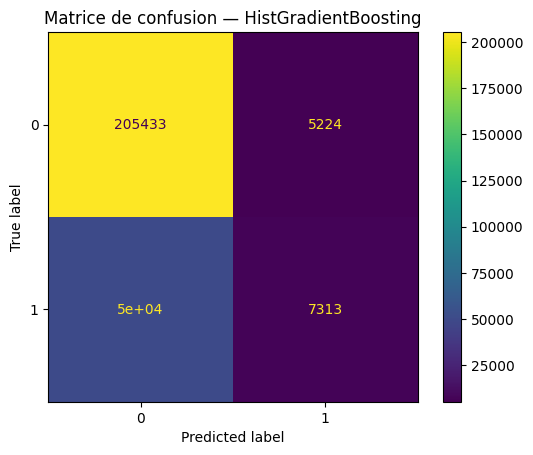

In [11]:
import matplotlib.pyplot as plt

best_name = results_df.iloc[0]['model']
best_model = fitted_models[best_name]
y_pred_best = best_model.predict(X_test)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best)
plt.title(f"Matrice de confusion — {best_name}")
plt.show()
